In [1]:
import numpy as np
from isochrones import get_ichrone
tracks = get_ichrone('mist', tracks=True)

FEH = -0.02 #0.02
LOG10AGE = np.log10(40e6)
LOGG = 4.59
RSTAR = 0.78
MSTAR = 0.86



Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [24]:
def mass_to_mag(mass1, mass2, mass3, log10age, feh, bandpass='TESS_mag'):
    mass1 = MSTAR
    star1 = tracks.generate(mass1, log10age, feh, return_dict=True) 
    mag1 = star1[bandpass]

    star2 = tracks.generate(mass2, log10age, feh, return_dict=True) 
    mag2 = star2[bandpass]

    star3 = tracks.generate(mass3, log10age, feh, return_dict=True) 
    mag3 = star3[bandpass]

    return mag1, mag2, mag3

In [25]:
def mag_to_flux(mag, const=1):
    """mag = 2.5*(F/F0)"""
    return const*10**(-0.4*mag)

In [26]:
def mag_to_depth(mag1, mag2, mag3):
    f1 = mag_to_flux(mag1)
    f2 = mag_to_flux(mag2)
    f3 = mag_to_flux(mag3)
    ie = f1+f2
    ooe = f1+f2+f3
    return 1-(ie/ooe)

In [27]:
def likelihood(model, data, err):
    return (1/np.sqrt(2*np.pi*err**2))*np.exp((data-model)/err)**2

In [28]:
mag1, mag2, mag3 = mass_to_mag(MSTAR, 0.1, 0.1, LOG10AGE, FEH)
mag1, mag2, mag3

(4.8410054878230016, 10.423467119535996, 10.423467119535996)

In [29]:
depth_true = mag_to_depth(mag1, mag2, mag3)
depth_true

0.005780497558861675

In [39]:
DEPTH_OBS = 1 #0.00113454
DEPTH_OBS_ERR = 0.1 #0.0005

likelihood(depth_true, DEPTH_OBS, DEPTH_OBS_ERR)

1724213098.576526

## mass grid

In [40]:
def plot_eclipse_depth_grid(mass_grid, cmap='default'):
    """
    """
    fig, ax = pl.subplots(1,1, figsize=(8,4))
    xmin, xmax = m2s[0], m2s[-1]
    ymin, ymax = m3s[0], m3s[-1]

    #plot matrix
    cbar = ax.imshow(mass_grid, 
                     origin='lower', 
                     interpolation='none', 
                     extent=[xmin, xmax, ymin, ymax], 
                     cmap=cmap
                    )
    pl.colorbar(cbar, ax=ax, #shrink=0.9,
                label='Likelihood', orientation="vertical")

    # add labels
    # ax.set_aspect(5)
    pl.setp(ax,
            xlim=(xmin,xmax),
            ylim=(ymin,ymax),
            xlabel='secondary star mass (Msun)',
            ylabel='tertiary star mass (Msun)'
           );
    return fig

In [41]:
import matplotlib.pyplot as pl
from tqdm import tqdm

N_samples = 20

m2s = np.linspace(0.1, 1, N_samples)
m3s = np.linspace(0.1, 1, N_samples)

passbands = 'TESS_mag J_mag H_mag K_mag'.split()

mass_grids = {} 
for bp in passbands:
    mass_grid = np.zeros((N_samples,N_samples))
    for i,m2 in tqdm(enumerate(m2s)): 
        for j,m3 in enumerate(m3s):
            mag1, mag2, mag3 = mass_to_mag(MSTAR, m2, m3, LOG10AGE, FEH, bandpass=bp)
            depth = mag_to_depth(mag1, mag2, mag3)
            ll = likelihood(depth, DEPTH_OBS, DEPTH_OBS_ERR)
            mass_grid[i,j] = ll
    mass_grids[bp] = mass_grid

20it [00:00, 117.66it/s]
20it [00:00, 123.49it/s]
20it [00:00, 129.77it/s]
20it [00:00, 129.08it/s]


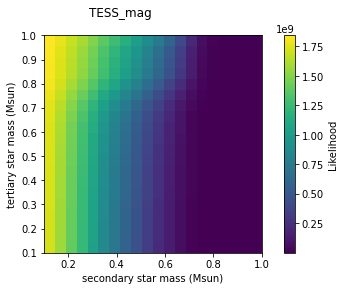

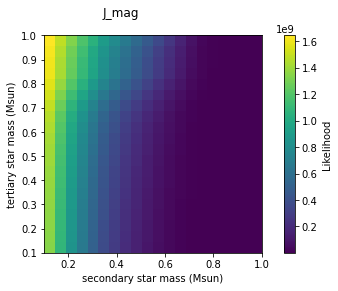

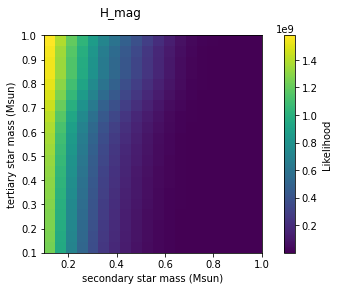

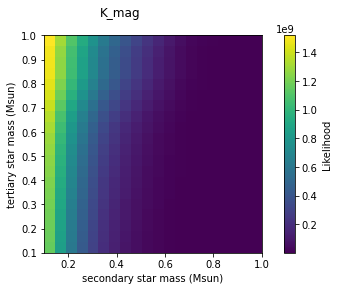

In [42]:
for bp in passbands:
    fig = plot_eclipse_depth_grid(mass_grids[bp], cmap='viridis')
    fig.suptitle(bp)